In [1]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,hour,dayofweek,to_timestamp,size,isnan,lit,date_format,to_timestamp,struct,expr,countDistinct
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType, DoubleType
from pyspark.ml.feature import QuantileDiscretizer

In [2]:
try:
    spark
except NameError:
    print('Create Spark')
    spark=SparkSession.builder.appName("").getOrCreate()

Create Spark


In [3]:
end_date='03/28/2020'
min_hour=9
max_hour=17

# source='cuebiq'
# country='US'
# admin_id='census_block_group'
# demographics=[
# 'population',
# 'median_age',
# 'median_income',
# 'state']
# to_decile=[
# 'population',
# 'median_age',
# 'median_income',
# ]

# source='cuebiq'
# country='MX'
# admin_id='ageb'
# demographics=[
# 'total_population',
# 'pop0_14',
# 'pop15_64',
# 'pob65_mas',
# 'wealth_index_10k',
# 'municipality_name',
# 'state_name']
# to_decile=[
# 'total_population',
# 'pop0_14',
# 'pop15_64',
# 'pob65_mas',
# 'wealth_index_10k',
# ]

# source='cuebiq'
# country='MX'
# demographics=[
# 'ADM1_ES',
# 'ADM2_ES',
# 'pop65_mas',
# ]
# to_decile=[
# 'pop65_mas',
# ]

source='cuebiq'
country='ID'
demographics=[
'ADM1_EN',
'ADM2_EN',
'median_age', 
'wealth_index',
'total_population',
]
to_decile=[
'median_age', 
'wealth_index',
'total_population',
]

if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/covid/data'
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
else:
    path_to_data='/user/spf248/covid/data'
    import matplotlib as mpl
    if os.environ.get('DISPLAY','') == '':
        mpl.use('Agg')
    import matplotlib.pyplot as plt
    import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Aggregated Data

In [4]:
n_pings_id_date=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_date')) # 1607730544
n_pings_id_personal_date=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_personal_date')) # 1569849911
personal_admin=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'personal_admin')) # 217190
primary_home=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'primary_home')) # 2132327
id_personal_most_freq_hour=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'id_personal_most_freq_hour')) # 2132327
users_profile=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'users_profile')) # 21783569

# Activity Per Day

In [5]:
def clean_dates(df):
    currentYear = datetime.now().year
    df['keep_date']=df.date.apply(lambda x:int(x.split('-')[0])==currentYear)
    df=df[df.keep_date==True].copy()
    df.drop('keep_date',1,inplace=True)
    df.date=pd.to_datetime(df.date)
    df.set_index('date',inplace=True)
    df.sort_index(inplace=True)
    return df

In [6]:
print('Save Primary Home Location')
start = timer()

n_users_date_pd=n_pings_id_date.groupby('date').agg(
countDistinct('cuebiq_id')).withColumnRenamed(
'count(DISTINCT cuebiq_id)','n_users').join(
n_pings_id_date.groupby('date').agg({'n_pings':'sum'}).withColumnRenamed(
'sum(n_pings)','n_pings'),on='date').toPandas()

print("Done in", round(timer()-start), "sec")     

Save Primary Home Location
Done in 47 sec


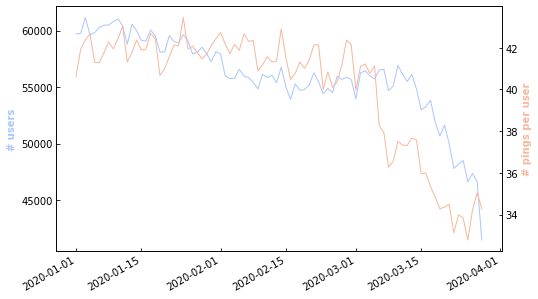

In [7]:
fig,ax1=plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

n_users_date_pd=clean_dates(n_users_date_pd)

data1=n_users_date_pd['n_users'].truncate(after=end_date)
ax1.plot(data1.index,data1.values,linewidth=1,color=sns.color_palette("coolwarm", 2)[0])
data2=n_users_date_pd['n_pings'].divide(n_users_date_pd['n_users']).truncate(after=end_date)
ax2.plot(data2.index,data2.values,linewidth=1,color=sns.color_palette("coolwarm", 2)[1])

ax1.tick_params(which='both',direction='in',pad=3)
ax2.tick_params(which='both',direction='in',pad=3)
ax1.locator_params(axis='y',nbins=6)
ax2.locator_params(axis='y',nbins=6)

ax1.set_xlabel('')
ax1.set_ylabel('# users',fontweight='bold',color=sns.color_palette("coolwarm", 2)[0])
ax2.set_ylabel('# pings per user',fontweight='bold',color=sns.color_palette("coolwarm", 2)[1])
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'activity-per-day.pdf'),bbox_inches='tight')

# Home Activity Per Day

In [8]:
print('Home Pings Per Day')
start = timer()

n_pings_id_home_date_pd=n_pings_id_personal_date.withColumnRenamed(
'n_pings','n_home').join(n_pings_id_date,on=['cuebiq_id','date']).join(
primary_home.select('cuebiq_id','point'),on=['cuebiq_id','point']).groupby(
'cuebiq_id','date').agg({'n_home':'sum','n_pings':'sum'}).withColumnRenamed(
'sum(n_home)','n_home').withColumnRenamed('sum(n_pings)','n_pings').toPandas()

n_pings_id_home_date_pd=clean_dates(n_pings_id_home_date_pd)
n_pings_id_home_date_pd=n_pings_id_home_date_pd.truncate(after=end_date)
n_pings_id_home_date_pd['pct_home']=n_pings_id_home_date_pd['n_home'].divide(
n_pings_id_home_date_pd['n_pings'])

print("Done in", round(timer()-start), "sec")

Home Pings Per Day
Done in 79 sec


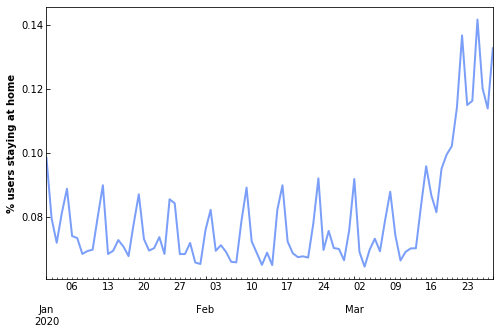

In [9]:
fig,ax=plt.subplots(figsize=(8,5))
data=n_pings_id_home_date_pd.groupby('date')['pct_home'].apply(
lambda x:(x==1).sum()/x.count())
data.plot(
ax=ax,linewidth=2,color=sns.color_palette("coolwarm", 4)[0])
ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.set_xlabel('')
ax.set_ylabel('% users staying at home',fontweight='bold')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'pct-users-staying-at-home.pdf'),bbox_inches='tight')

# Commuting Patterns

In [26]:
print('Work Pings Per Day')
start = timer()

n_pings_work_date=n_pings_id_date.join(n_pings_id_personal_date.withColumnRenamed(
'n_pings','n_work').join(id_personal_most_freq_hour.filter(
id_personal_most_freq_hour['most_freq_hour']<max_hour).filter(
id_personal_most_freq_hour['most_freq_hour']>=min_hour),
on=['cuebiq_id','point']).drop('most_freq_hour','point'),on=['cuebiq_id','date'],how='left')

n_pings_work_date_pd=n_pings_work_date.groupby('cuebiq_id','date').agg(
{'n_pings':'count','n_work':'count'}).withColumnRenamed(
'count(n_pings)','n_pings').withColumnRenamed(
'count(n_work)','n_work').toPandas()

print("Done in", round(timer()-start), "sec")

Work Pings Per Day


Py4JJavaError: An error occurred while calling o548.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:282)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:278)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.foreach(SparkPlan.scala:278)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:300)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:299)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:186)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


# Merge Home Pings

In [ ]:
to_keep=[
'cuebiq_id',
'date',
'n_home',
'n_pings',
# 'n_days',
# 'n_personal',
# 'device_type',
]+demographics

n_pings_id_home_date=n_pings_id_personal_date.withColumnRenamed('n_pings','n_home').join(n_pings_id_date,on=['cuebiq_id','date'])
n_pings_id_home_date=n_pings_id_home_date.join(primary_home.select('cuebiq_id','point'),on=['cuebiq_id','point'])
print('# Obs:',n_pings_id_home_date.count())
n_pings_id_home_date=n_pings_id_home_date.join(personal_admin,on=['point'])
print('# Obs:',n_pings_id_home_date.count())
# n_pings_id_home_date=n_pings_id_home_date.join(users_profile.drop('n_pings'),on=['cuebiq_id'])
n_pings_id_home_date=n_pings_id_home_date.select(to_keep)

print(n_pings_id_home_date.printSchema())

# Discretize Demographics

In [ ]:
n_pings_id_home_date=n_pings_id_home_date.select(*(col(c).cast("float").alias(c) 
if c in to_decile else col(c) for c in n_pings_id_home_date.columns))
n_pings_id_home_date.cache()
print('# Obs:', n_pings_id_home_date.count())

for _var in to_decile:
    print('Discretize:', _var)
    qds=QuantileDiscretizer(
    numBuckets=10, 
    inputCol=_var, 
    outputCol=_var+"_decile")
    n_pings_id_home_date=qds.fit(n_pings_id_home_date).setHandleInvalid("skip").transform(n_pings_id_home_date)
print(n_pings_id_home_date.printSchema())

In [ ]:
n_pings_date_admin=n_pings_id_home_date.groupby(
['date']+[x+'_decile' if x in to_decile else x for x in demographics]).agg(
{'n_home':'sum','n_pings':'sum'}).withColumnRenamed(
'sum(n_home)','n_home').withColumnRenamed(
'sum(n_pings)','n_pings')

In [ ]:
n_pings_date_admin.write.mode("overwrite").parquet(
os.path.join(path_to_data,source,'aggregates',country,'n_pings_date_admin'))

In [ ]:
n_pings_id_date_pd

# FIGURES

In [ ]:
print('Load Primary Home Location')
start = timer()

n_pings_id_home_date_pd={}
for country in ['US','MX','ID']:
    n_pings_id_home_date_pd[country]=n_pings_id_home_date=spark.read.parquet(
    os.path.join(path_to_data,source,'aggregates',country,'home_presence')).toPandas()
    
print("Done in", round(timer()-start), "sec")     

In [ ]:
for country in ['US','MX','ID']:
    
    currentYear = datetime.now().year
    n_pings_id_home_date_pd[country]['keep_date']=n_pings_id_home_date_pd[country].date.apply(lambda x:int(x.split('-')[0])==currentYear)
    n_pings_id_home_date_pd[country]=n_pings_id_home_date_pd[country].loc[n_pings_id_home_date_pd[country].keep_date==True].copy()
    n_pings_id_home_date_pd[country].date=pd.to_datetime(n_pings_id_home_date_pd[country].date)
    n_pings_id_home_date_pd[country]=n_pings_id_home_date_pd[country][n_pings_id_home_date_pd[country].date<date_range.iloc[-1]].copy()
    n_pings_id_home_date_pd[country].drop('keep_date',1,inplace=True)

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
for i,country in enumerate(['US','MX','ID']):
    n_pings_id_home_date_pd[country].groupby('date').agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).truncate(before=datetime.now()-timedelta(days = 75)).plot(
    ax=ax,label=country,color=sns.color_palette("coolwarm", 3)[i])
    ax.set_ylim([0,100])
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xlabel('')
    ax.set_ylabel('% pings at home',fontweight='bold')
    ax.legend(loc='best')

In [ ]:
for country in ['US','MX','ID']:
    print(country,n_pings_id_home_date_pd[country].groupby('date').agg(
{'n_home':'sum','n_pings':'sum'}).apply(
lambda x:x.n_home/x.n_pings*100,1).truncate(before=datetime.now()-timedelta(days = 20)).mean()/n_pings_id_home_date_pd[country].groupby('date').agg(
{'n_home':'sum','n_pings':'sum'}).apply(
lambda x:x.n_home/x.n_pings*100,1).mean()-1)

# FIGURES

In [ ]:
n_pings_id_home_date=spark.read.parquet(
os.path.join(path_to_data,source,'aggregates',country,'home_presence'))

In [ ]:
print('Save Primary Home Location')
start = timer()
n_pings_id_home_date_pd=n_pings_id_home_date.toPandas()
print("Done in", round(timer()-start), "sec")     

In [ ]:
date_range=pd.Series(sorted([
pd.to_datetime(x.split('/')[-1][:-2],format='%Y%m%d') 
for x in glob(os.path.join(path_to_data,source,'s3',country,'2020*'))]))

In [ ]:
n_pings_id_home_date_pd.sort_values(
by=['date']+[x+'_decile' if x in to_decile else x for x in demographics],inplace=True)

currentYear = datetime.now().year
n_pings_id_home_date_pd['keep_date']=n_pings_id_home_date_pd.date.apply(lambda x:int(x.split('-')[0])==currentYear)
n_pings_id_home_date_pd=n_pings_id_home_date_pd.loc[n_pings_id_home_date_pd.keep_date==True].copy()
n_pings_id_home_date_pd.date=pd.to_datetime(n_pings_id_home_date_pd.date)
n_pings_id_home_date_pd=n_pings_id_home_date_pd[n_pings_id_home_date_pd.date<date_range.iloc[-1]].copy()
n_pings_id_home_date_pd.drop('keep_date',1,inplace=True)

In [ ]:
range_by_state=n_pings_id_home_date_pd.groupby(['state_name','date']).agg(
{'n_home':'sum','n_pings':'sum'}).apply(
lambda x:x.n_home/x.n_pings,1).groupby('state_name').apply(
lambda x:(x.max()-x.min())/x.mean()).sort_values()

In [ ]:
range_by_state

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
for i,state in enumerate(['Nuevo León','Yucatán','Oaxaca','Chiapas']):
    n_pings_id_home_date_pd.groupby(['state_name','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[state].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=state,linewidth=2,color=sns.color_palette("coolwarm", 4)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-state.pdf'),bbox_inches='tight')

In [ ]:
for i,(income_group,income_label) in enumerate(zip([0,9],['Lowest income decile','Highest income decile'])):
    
    print(n_pings_id_home_date_pd.groupby(['median_income_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[income_group].truncate(before=datetime.now()-timedelta(days = 25)).mean()/n_pings_id_home_date_pd.groupby(['median_income_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[income_group].mean()-1)

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
for i,(income_group,income_label) in enumerate(zip([0,9],['Lowest income decile','Highest income decile'])):
    n_pings_id_home_date_pd.groupby(['median_income_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[income_group].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=income_label,linewidth=2,color=sns.color_palette("coolwarm", 2)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-income-group.pdf'),bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
for i,(population_group,population_label) in enumerate(zip([0,9],['Lowest population decile','Highest population decile'])):
    n_pings_id_home_date_pd.groupby(['total_population_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[population_group].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=population_label,linewidth=2,color=sns.color_palette("coolwarm", 2)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-population-group.pdf'),bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
for i,(age_group,age_label) in enumerate(zip([0,9],['Lowest decile of pop.>65','Highest decile of pop.>65'])):
    n_pings_id_home_date_pd.groupby(['pob65_mas_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[age_group].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=age_label,linewidth=2,color=sns.color_palette("coolwarm", 2)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-age-group.pdf'),bbox_inches='tight')